   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 18.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model Performance Metrics:
MSE: 99.8297
RMSE: 9.9915
MAE: 6.1040
R²: 0.9975
MAPE: 0.27%


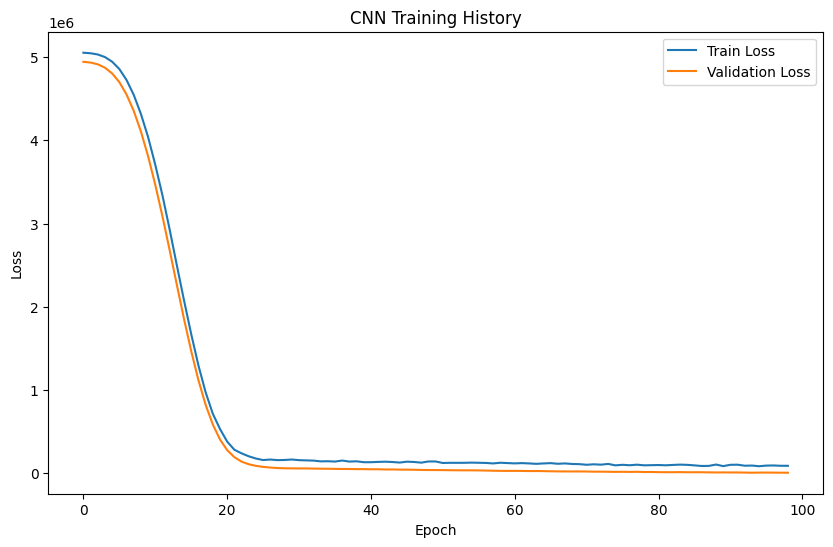

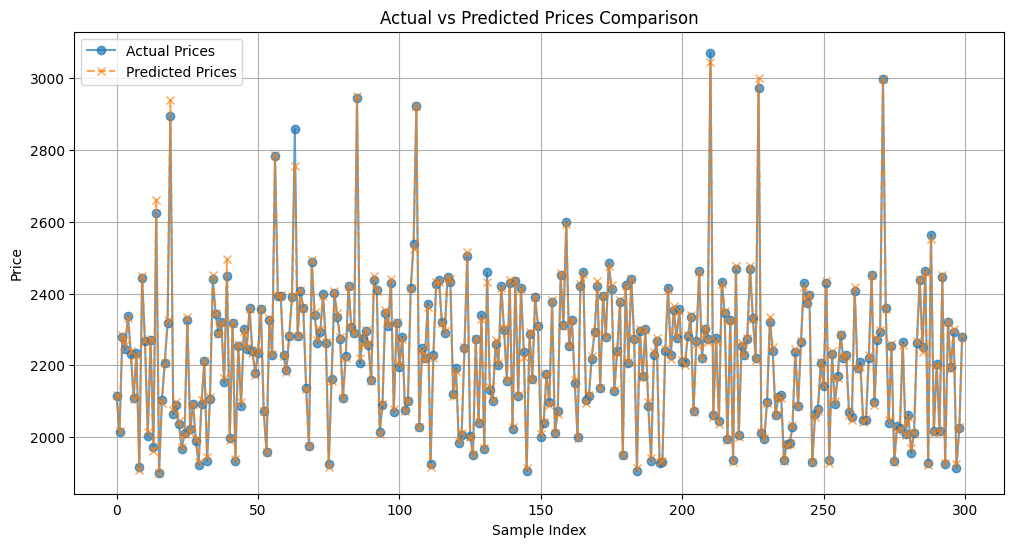

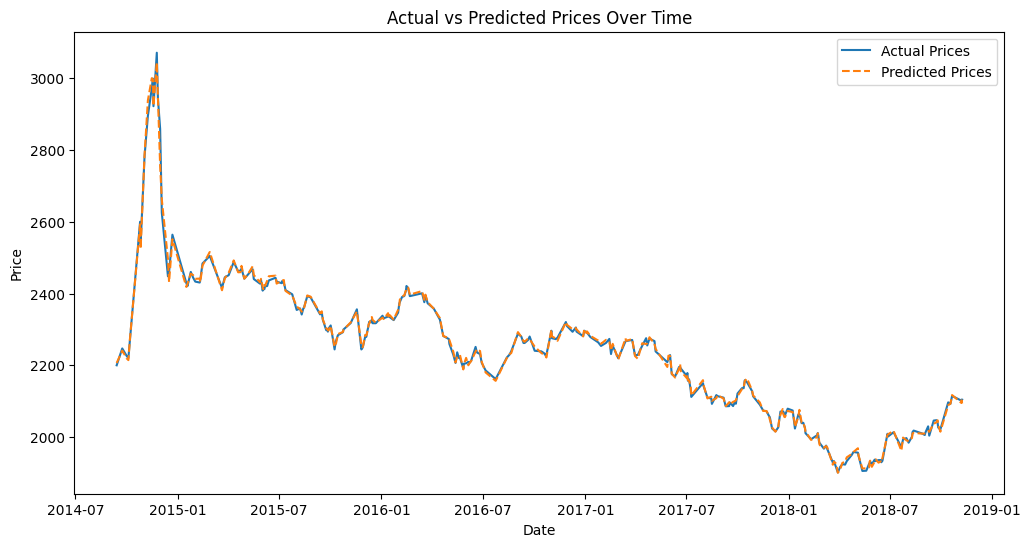

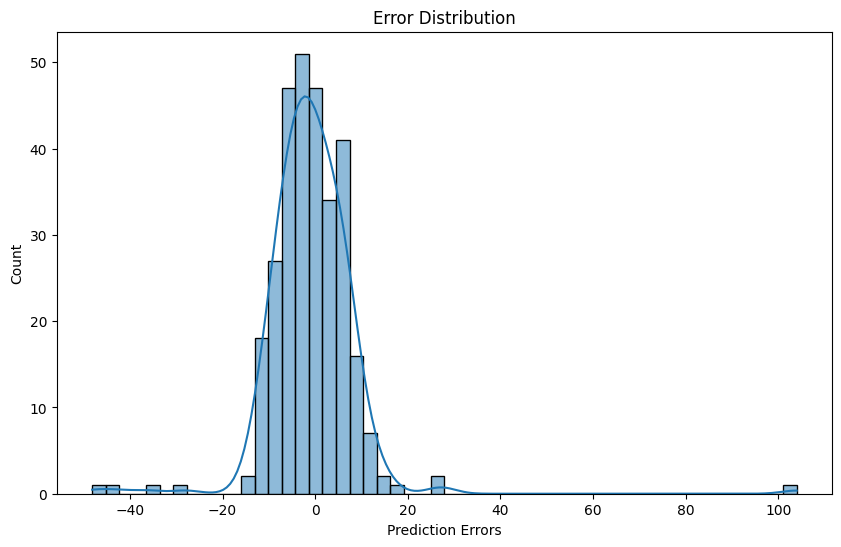

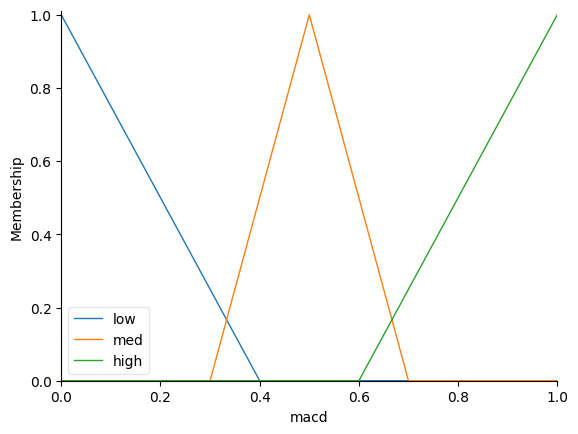

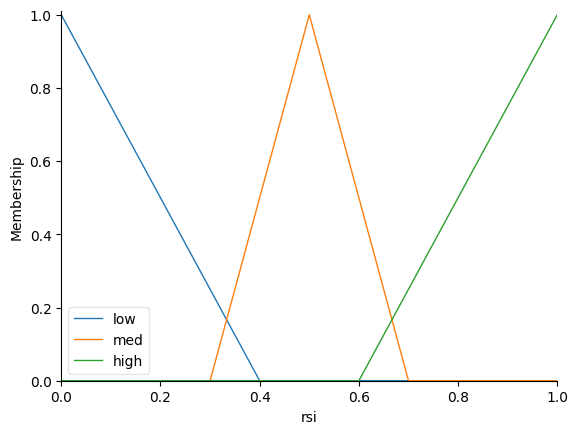

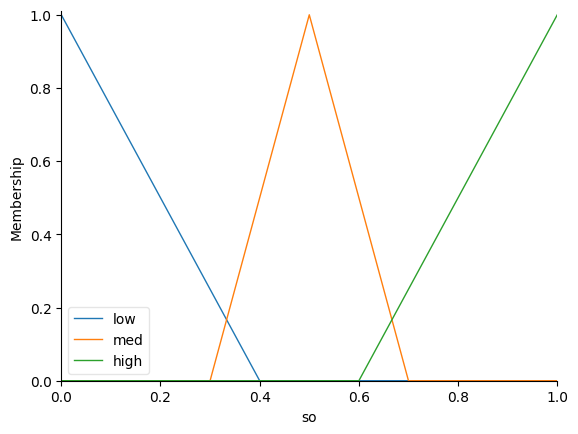

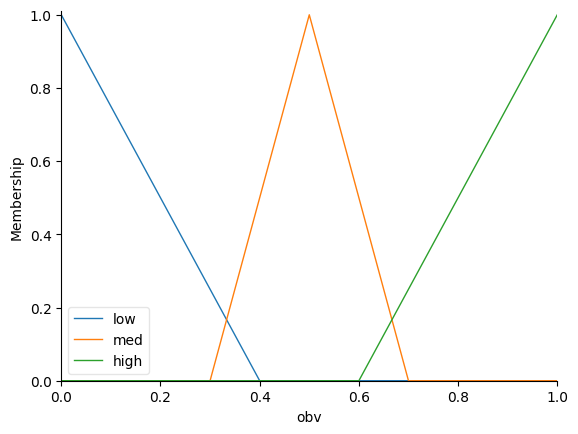

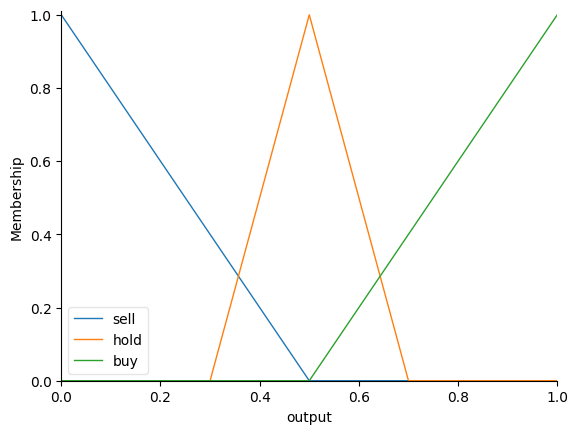


Sample Predictions:
      Date  Actual   Predicted
2014-09-13  2200.0 2206.543873
2014-09-23  2247.0 2240.859114
2014-10-01  2226.0 2219.353614
2014-10-04  2220.0 2214.468794
2014-10-07  2274.0 2276.960536
2014-10-25  2600.0 2592.572300
2014-10-26  2539.0 2524.708628
2014-11-02  2782.0 2786.239265
2014-11-08  2895.0 2938.116173
2014-11-15  2972.0 2999.984378


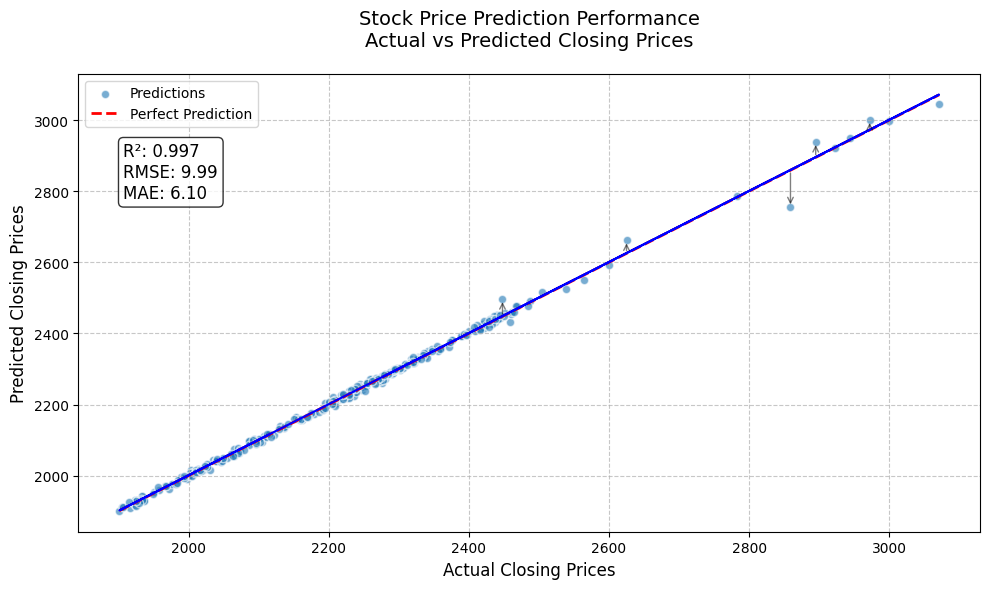

Original Data (First 5 Rows):
        date    open    high     low   close   volume
0 2014-08-23  2350.0  2384.0  2310.0  2336.0  1487026
1 2014-08-24  2365.0  2365.0  2290.0  2329.0   609119
2 2014-08-25  2299.0  2319.0  2290.0  2321.0   699732
3 2014-08-26  2300.0  2324.0  2281.0  2314.0  1100743
4 2014-08-27  2245.0  2310.0  2245.0  2301.0  1593849

Original Data (Last 5 Rows):
           date         open         high          low        close  volume
1495 2018-11-12  2109.235091  2129.226623  2089.924956  2109.918466       0
1496 2018-11-13  2111.813415  2122.347782  2103.639825  2111.031073       0
1497 2018-11-14  2120.432981  2133.016336  2115.627548  2130.482011       0
1498 2018-11-15  2138.021292  2141.599085  2135.927574  2138.925182       0
1499 2018-11-16  2148.840064  2152.140469  2147.917480  2148.532701       0
--------------------------------------------------

After Sorting by Date (First 5 Rows):
        date    open    high     low   close   volume
0 2014-08-23  23

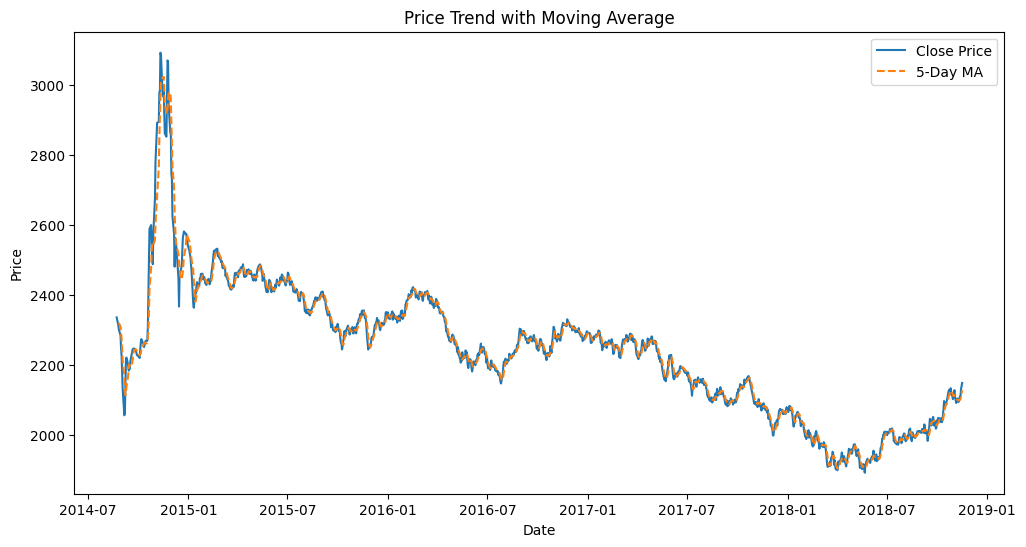

In [ ]:
!pip install scikit-fuzzy
!pip install tensorflow
!pip install seaborn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# 1. Data Loading & Preprocessing
# ------------------------
def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)

    # Clean date and sort
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data.dropna(subset=['date'], inplace=True)
    data.sort_values('date', inplace=True)

    # Calculate MACD
    data['ema_12'] = data['close'].ewm(span=12, adjust=False).mean()
    data['ema_26'] = data['close'].ewm(span=26, adjust=False).mean()
    data['macd'] = data['ema_12'] - data['ema_26']
    data['ema_9_signal'] = data['macd'].ewm(span=9, adjust=False).mean()

    # Calculate RSI
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss.replace(0, np.nan)
    data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate Stochastic Oscillator (%K)
    low_min = data['low'].rolling(window=14).min()
    high_max = data['high'].rolling(window=14).max()
    data['%K'] = 100 * ((data['close'] - low_min) / (high_max - low_min))

    # Calculate OBV
    data['OBV'] = (np.sign(data['close'].diff()) * data['volume']).fillna(0).cumsum()

    return data

data = load_and_preprocess_data('New Bank data.xlsx')

# ------------------------
# 2. Fuzzy Logic System Setup
# ------------------------
scaler = MinMaxScaler()
indicators = data[['macd', 'RSI', '%K', 'OBV']]
indicators_normalized = pd.DataFrame(scaler.fit_transform(indicators),
                                    columns=['macd_norm', 'rsi_norm', 'so_norm', 'obv_norm'])

# Define fuzzy variables
macd = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'macd')
rsi = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'rsi')
so = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'so')
obv = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'obv')
output = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'output')

for var in [macd, rsi, so, obv]:
    var['low'] = fuzz.trimf(var.universe, [0, 0, 0.4])
    var['med'] = fuzz.trimf(var.universe, [0.3, 0.5, 0.7])
    var['high'] = fuzz.trimf(var.universe, [0.6, 1, 1])

output['sell'] = fuzz.trimf(output.universe, [0, 0, 0.5])
output['hold'] = fuzz.trimf(output.universe, [0.3, 0.5, 0.7])
output['buy'] = fuzz.trimf(output.universe, [0.5, 1, 1])

rules = [
    ctrl.Rule(macd['high'] & rsi['low'] & so['low'] & obv['high'], output['buy']),
    ctrl.Rule(macd['low'] & rsi['high'] & so['high'] & obv['low'], output['buy']),
    ctrl.Rule(rsi['low'] & so['low'] & obv['high'], output['buy']),
    ctrl.Rule(macd['low'] & rsi['med'] & so['high'] & obv['low'], output['sell']),
    ctrl.Rule(rsi['high'] & so['high'] & obv['low'], output['sell']),
    ctrl.Rule(macd['low'] & rsi['high'] & so['high'], output['sell']),
    ctrl.Rule(macd['low'] & rsi['med'] & so['med'], output['hold']),
    ctrl.Rule(macd['high'] & rsi['med'] & so['med'] & obv['low'], output['hold'])
]

fuzzy_ctrl = ctrl.ControlSystem(rules)
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_ctrl)

def get_fuzzy_output(row):
    try:
        fuzzy_sim.input['macd'] = row['macd_norm']
        fuzzy_sim.input['rsi'] = row['rsi_norm']
        fuzzy_sim.input['so'] = row['so_norm']
        fuzzy_sim.input['obv'] = row['obv_norm']
        fuzzy_sim.compute()
        return fuzzy_sim.output['output']
    except:
        return 0.5

indicators_normalized['fuzzy_signal'] = indicators_normalized.apply(get_fuzzy_output, axis=1)

# ------------------------
# 3. CNN Feature Extraction with Regularization
# ------------------------
X = data[['open', 'high', 'low', 'volume']]
y = data['close']

scaler_cnn = MinMaxScaler()
X_scaled = scaler_cnn.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Enhanced CNN model with regularization
cnn_model = Sequential([
    Conv1D(64, 2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=regularizers.l2(0.01))
])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss='mse')

history = cnn_model.fit(X_train_cnn, y_train,
                      epochs=100,
                      validation_split=0.2,
                      callbacks=[early_stop],
                      verbose=0)

cnn_features_train = cnn_model.predict(X_train_cnn)
cnn_features_test = cnn_model.predict(X_test_cnn)

# ------------------------
# 4. Combine Features & Regularized Regression
# ------------------------
train_indices, test_indices = train_test_split(data.index, test_size=0.2, random_state=42)
fuzzy_train = indicators_normalized.loc[train_indices, 'fuzzy_signal'].values.reshape(-1,1)
fuzzy_test = indicators_normalized.loc[test_indices, 'fuzzy_signal'].values.reshape(-1,1)

X_train_combined = np.hstack((cnn_features_train, fuzzy_train))
X_test_combined = np.hstack((cnn_features_test, fuzzy_test))

# Use Ridge regression with regularization
reg_model = Ridge(alpha=0.5)
reg_model.fit(X_train_combined, y_train)
y_pred = reg_model.predict(X_test_combined)

# ------------------------
# 5. Enhanced Evaluation & Visualization
# ------------------------
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Training history plot
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Actual vs Predicted Prices plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred, label='Predicted Prices', marker='x', linestyle='--', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Time series comparison
test_dates = data.loc[test_indices, 'date']
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test,
    'Predicted': y_pred
}).sort_values('Date')

plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual Prices')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices Over Time')
plt.legend()
plt.show()

# Error distribution
plt.figure(figsize=(10, 6))
sns.histplot((y_test - y_pred), kde=True)
plt.xlabel('Prediction Errors')
plt.title('Error Distribution')
plt.show()

# Fuzzy membership visualization
macd.view()
rsi.view()
so.view()
obv.view()
output.view()
plt.show()

print("\nSample Predictions:")
print(results_df[['Date', 'Actual', 'Predicted']].head(10).to_string(index=False))

# Enhanced actual vs predicted prices plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='#1f77b4', edgecolors='w', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Closing Prices', fontsize=12)
plt.ylabel('Predicted Closing Prices', fontsize=12)
plt.title('Stock Price Prediction Performance\nActual vs Predicted Closing Prices', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add regression line for trend
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "b-", lw=1.5, label='Best Fit Line')

# Add metrics text box
textstr = f'R²: {r2:.3f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}'
plt.text(0.05, 0.85, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Highlight largest discrepancies
top_errors = np.argsort(np.abs(y_test - y_pred))[-5:]
for i in top_errors:
    plt.annotate('', xy=(y_test.iloc[i], y_pred[i]),
                 xytext=(y_test.iloc[i], y_test.iloc[i]),
                 arrowprops=dict(arrowstyle="->", color='black', alpha=0.5))

plt.tight_layout()
plt.show()


import pandas as pd


# 1. Load existing data
df = pd.read_excel('New Bank data.xlsx', sheet_name='Sheet1')
print("Original Data (First 5 Rows):")
print(df.head())
print("\nOriginal Data (Last 5 Rows):")
print(df.tail())
print("-"*50)

# 2. Ensure 'date' is in datetime format and sort chronologically
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
print("\nAfter Sorting by Date (First 5 Rows):")
print(df.head())
print("\nAfter Sorting by Date (Last 5 Rows):")
print(df.tail())
print("-"*50)

# 3. Recalculate metrics (e.g., 5-day moving average)
df['5_day_MA'] = df['close'].rolling(window=5).mean()
print("\nWith 5-Day Moving Average (First 5 Rows):")
print(df[['date', 'close', '5_day_MA']].head(10))  # Show first 10 to see MA calculation
print("-"*50)

# 4. Prepare new data
new_data = {
    'date': ['2017-05-28', '2017-05-29', '2017-05-30'],
    'open': [2192.5, 2206.0, 2219.0],
    'high': [2210.3, 2225.9, 2234.6],
    'low': [2185.4, 2200.1, 2205.8],
    'close': [2205.75, 2218.20, 2227.45],
    'volume': [580, 620, 590]
}
new_df = pd.DataFrame(new_data)
new_df['date'] = pd.to_datetime(new_df['date'])
print("\nNew Data to Add:")
print(new_df)
print("-"*50)

# 5. Combine and re-sort
df = pd.concat([df, new_df]).sort_values('date')
print("\nCombined Data (Last 5 Rows):")
print(df.tail())
print("-"*50)

# 6. Recalculate metrics
df['5_day_MA'] = df['close'].rolling(window=5).mean()
print("\nFinal Data with Recalculated MA (Last 10 Rows):")
print(df[['date', 'close', '5_day_MA']].tail(10))  # Focus on the newly added period
print("-"*50)

# 7. Save
df.to_excel('Updated_Bank_Data.xlsx', index=False)
print("Data saved to 'Updated_Bank_Data.xlsx'")

import matplotlib.pyplot as plt

# Plot closing price and moving average
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'], label='Close Price')
plt.plot(df['date'], df['5_day_MA'], label='5-Day MA', linestyle='--')
plt.title('Price Trend with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()